In [507]:
import os

import pandas as pd
import numpy as np

In [508]:
df = pd.read_csv(os.path.join(os.getcwd(), "data/20240603/LW-2_20240603_180436_243.csv"), skiprows=11)

In [509]:
df.head()

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Status
0,1,52328857,129.046448,-32.256260,102.086807,0.257977,0.045286,-0.402154,0
1,2,52345524,128.625671,-32.209942,102.112373,0.401934,0.212810,-0.619384,0
2,3,52362191,127.969780,-32.288712,102.377968,0.420225,0.332586,-0.752239,0
3,4,52378858,127.366692,-32.471802,102.806702,0.301588,0.226279,-0.693470,0
4,5,52395525,126.966003,-32.650444,103.217415,0.237055,0.163963,-0.472943,0


In [510]:
df["FreeAccMagnitude"] = (df["FreeAcc_X"]**2 + df["FreeAcc_Y"]**2 + df["FreeAcc_Z"]**2)**0.5

<Axes: >

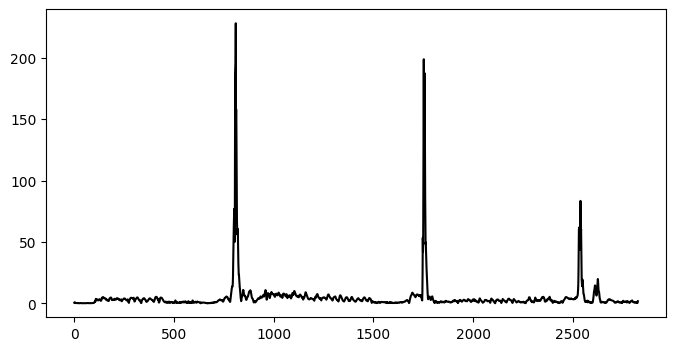

In [511]:
df["FreeAccMagnitude"].plot(figsize=(8, 4), c='black')

In [512]:
# use isolation forest to detect anomalies
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.015)
clf.fit(df[["FreeAccMagnitude"]])

IsolationForest(contamination=0.015)

In [513]:
# predict the anomalies
df["Anomaly"] = clf.predict(df[["FreeAccMagnitude"]])

In [514]:
df["Anomaly"].value_counts()

Anomaly
 1    2785
-1      43
Name: count, dtype: int64

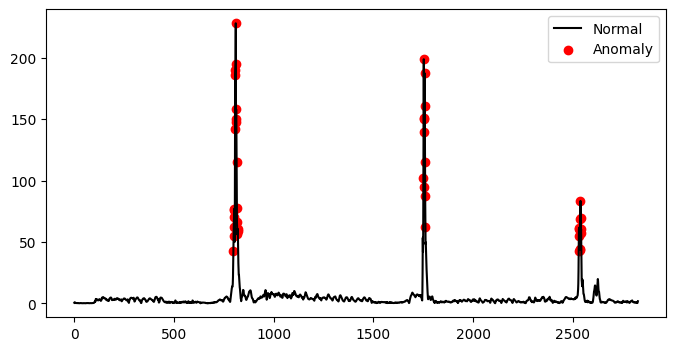

In [515]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
anomalies = df.loc[df['Anomaly'] == -1, ['FreeAccMagnitude']]  # Anomaly
ax.plot(df.index, df['FreeAccMagnitude'], color='black', label='Normal')
ax.scatter(anomalies.index, anomalies['FreeAccMagnitude'], color='red', label='Anomaly')
plt.legend()
plt.show()

In [516]:
# get list of timestamps of anomalies
anomalies = np.array(df.loc[df['Anomaly'] == -1].index.tolist()).reshape(-1, 1)

In [517]:
anomalies

array([[ 798],
       [ 799],
       [ 800],
       [ 801],
       [ 802],
       [ 803],
       [ 806],
       [ 807],
       [ 808],
       [ 809],
       [ 810],
       [ 811],
       [ 812],
       [ 813],
       [ 814],
       [ 815],
       [ 816],
       [ 817],
       [ 818],
       [ 819],
       [ 820],
       [1751],
       [1752],
       [1753],
       [1754],
       [1755],
       [1756],
       [1757],
       [1758],
       [1759],
       [1760],
       [1761],
       [2530],
       [2531],
       [2532],
       [2533],
       [2535],
       [2537],
       [2538],
       [2539],
       [2540],
       [2541],
       [2542]])

In [518]:
# automaize the elbow method with kneed
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

3

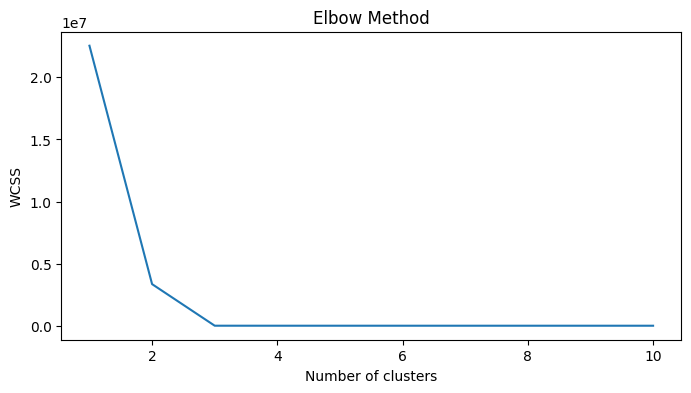

In [519]:
# iterate number of n_clusters and find where the elbow is
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(anomalies)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [520]:
# k means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=kl.elbow, random_state=0)
kmeans.fit(anomalies)

KMeans(n_clusters=3, random_state=0)

In [521]:
cluster_representatives = kmeans.cluster_centers_.round().astype(int).reshape(-1,)
cluster_representatives

array([1756,  809, 2536])

In [522]:
df["AnomalyGroup"] = 0
df.loc[cluster_representatives, "AnomalyGroup"] = 1

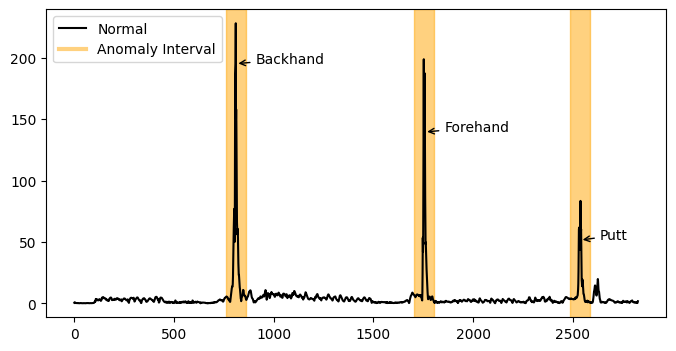

In [532]:
import matplotlib.pyplot as plt

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
anomalies = df.loc[df['AnomalyGroup'] == 1, ['FreeAccMagnitude']]  # Anomaly
ax.plot(df.index, df['FreeAccMagnitude'], color='black', label='Normal')
# ax.scatter(anomalies.index, anomalies['FreeAccMagnitude'], color='red', label='Anomaly', s=100)

# Add color intervals
for index, row in anomalies.iterrows():
    start_index = max(0, index - 50)  # Start index of the color interval
    end_index = min(len(df.index) - 1, index + 50)  # End index of the color interval
    ax.axvspan(df.index[start_index], df.index[end_index], color='orange', alpha=0.5)

# add legend for the color intervals
ax.plot([], [], color='orange', alpha=0.5, label='Anomaly Interval', linewidth=3)

# add pointers to the anomalies indicating that first intervals shows backhand, seocond interval shows forehand and last a putt
ax.annotate('Backhand', xy=(anomalies.index[0], anomalies['FreeAccMagnitude'].values[0]), xytext=(anomalies.index[0] + 100, anomalies['FreeAccMagnitude'].values[0] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Forehand', xy=(anomalies.index[1], anomalies['FreeAccMagnitude'].values[1]), xytext=(anomalies.index[1] + 100, anomalies['FreeAccMagnitude'].values[1] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
ax.annotate('Putt', xy=(anomalies.index[2], anomalies['FreeAccMagnitude'].values[2]), xytext=(anomalies.index[2] + 100, anomalies['FreeAccMagnitude'].values[2] + 0.5),
            arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.legend()
plt.show()